<a href="https://colab.research.google.com/github/SSPedersen/VAE-and-LVAE-Super-Resolution/blob/main/VAE_and_LVAE_Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution

sns.set_style("whitegrid")

try:
    from plotting import make_vae_plots
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

If using Colab, you may need to upload `plotting.py`.           
In the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer           
---------------------------------------------
No module named 'plotting'


In [ ]:
 %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn  import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, ConvTranspose2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

import os
import pickle
import numpy as np

from PIL import Image
from torch.utils.data import Dataset
from skimage.transform import resize
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split

from torch.utils.data import Subset
from torch.utils.data import DataLoader

from torch.distributions import Normal

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
          #Reparameterization trick
        return self.mu+self.sigma*self.sample_epsilon() # <- your code
          
      
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        dist = torch.distributions.Normal(self.mu, self.sigma)
        return dist.log_prob(z) # <- your code

In [ ]:
h, w, c = 32, 32, 3
dh, dw, dc = 16, 16, 3

class CIFAR(Dataset):
    """CIFAR10 dataset"""

    def __init__(self, data, transform=None):

      self.data1 = np.ascontiguousarray(data.reshape(-1, h, w, c), dtype=np.float32)
      x = np.copy((data1))

      x = torch.tensor(x)
      print(f">> x : {x.shape}")
      x = transform.Resize((dc, dw, dh))
      print(f">>>> x : {x.shape}")

      self.downSampledData = x


      #self.downSampledData = np.ascontiguousarray(data.reshape(-1, dh, dw, c), dtype=np.float32)
      print("hej", data.shape)
      print("hej", self.data1.shape)
      #print("hej", self.downSampledData.shape)
      self.transform = transform

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      sample = self.data1[idx]
      downSample = self.downSampledData[idx]

      sample = Image.fromarray(255 * sample, mode= 'RGB') # cannot read bytes directly: https://github.com/numpy/numpy/issues/5861
      downSample = Image.fromarray(255 * downSample, mode= 'RGB') 
      # sample = Image.fromarray(sample/255, mode= 'RGB') # cannot read bytes directly: https://github.com/numpy/numpy/issues/5861
      # downSample = Image.fromarray(downSample/255, mode= 'RGB') 

      if self.transform:
        downSample = self.transform(downSample)
      return sample, downSample



class CIFAR(CIFAR10):
    """CIFAR10 dataset"""

    def __init__(self, *args, **kwargs):
      super().__init__(*args, **kwargs)

      

      # resizing
      resize_fn = transforms.Resize((dh, dw))
      x = torch.tensor(self.data).permute(0, 3, 1, 2) # BHWC -> BCHW
      x = resize_fn(x).permute(0, 2, 3, 1) # BCHW -> BHWC


      self.downsampled_data = x.numpy()

    def __getitem__(self, idx):

      x,_ = super().__getitem__(idx)

      y = self.downsampled_data[idx]

      if self.transform is not None:
        y = self.transform(y)

      return x, y



dset = CIFAR(root='./data', train=True, download=True, transform=transforms.Compose([
                                                                                     transforms.ToTensor(),
                                                                                    #  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                    #                       std=[0.229, 0.224, 0.225])
                                                                                    #  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                                                    #                       std=[0.5, 0.5, 0.5])
                                                                                     ]))


def reduce_dataset(dataset, reduction):
    discarded_idx, reduced_idx = train_test_split(list(range(len(dataset))), test_size=reduction)
    reduced_dataset = Subset(dataset, reduced_idx)
    return reduced_dataset

def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


r_dataset = reduce_dataset(dset, 0.01)

datasets = train_val_dataset(r_dataset)

train_set = datasets['train']
valid_set = datasets['val'] 

dloader = {x:DataLoader(datasets[x], batch_size=1, shuffle=True, num_workers=4) for x in ['train','val']}


train_data_iter = iter(dloader['train'])
val_data_iter = iter(dloader['val'])

images, downscaled = next(train_data_iter)
# print(images[0])

Extracting ./data/cifar-10-python.tar.gz to ./data


## Building the model


In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [ ]:
class GetSize(torch.nn.Module):
  def init(self):
    super(GetSize, self).init()

  def forward(self, x):
    print(x.shape)
    return x

# Residual block structure

In [ ]:
def get_conv(in_dim, out_dim, kernel_size, stride, padding, zero_bias=True, zero_weights=False, groups=1, scaled=False):
    c = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding, groups=groups)
    if zero_bias:
        c.bias.data *= 0.0
    if zero_weights:
        c.weight.data *= 0.0
    return c


def get_3x3(in_dim, out_dim, zero_bias=True, zero_weights=False, groups=1, scaled=False):
    return get_conv(in_dim, out_dim, 3, 1, 1, zero_bias, zero_weights, groups=groups, scaled=scaled)


def get_1x1(in_dim, out_dim, zero_bias=True, zero_weights=False, groups=1, scaled=False):
    return get_conv(in_dim, out_dim, 1, 1, 0, zero_bias, zero_weights, groups=groups, scaled=scaled)


In [ ]:
class Block(nn.Module):
    def __init__(self, in_width, middle_width, out_width, down_rate=None, residual=False, use_3x3=True, zero_last=False):
        super().__init__()
        self.down_rate = down_rate
        self.residual = residual
        self.c1 = get_1x1(in_width, middle_width)
        self.c2 = get_3x3(middle_width, middle_width) if use_3x3 else get_1x1(middle_width, middle_width)
        self.c3 = get_3x3(middle_width, middle_width) if use_3x3 else get_1x1(middle_width, middle_width)
        self.c4 = get_1x1(middle_width, out_width, zero_weights=zero_last)

    def forward(self, x):
        # print(x.shape)
        xhat = self.c1(F.gelu(x))
        # print(xhat.shape)
        xhat = self.c2(F.gelu(xhat))
        # print(xhat.shape)
        xhat = self.c3(F.gelu(xhat))
        # print(xhat.shape)
        xhat = self.c4(F.gelu(xhat))
        # print(xhat.shape)
        out = x + xhat if self.residual else xhat
        if self.down_rate is not None:
            out = F.avg_pool2d(out, kernel_size=self.down_rate, stride=self.down_rate)
        # print(out.shape)
        return out


# Model Structure

In [ ]:
# define vae
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)

        self.log_std = nn.Parameter(1e-6*torch.ones(1), requires_grad=False)  # Callback for fixing unstable variance 
                                                                              # The parameters will be very large therefor 1e-2 as this will create a smaller value 
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

        self.in_conv = get_3x3(3, 32)
        self.in_conv2 = get_3x3(3, 16)
        self.in_conv3 = get_3x3(3, 8)

        self.conv_stage1 = get_3x3(32, 16)
        self.conv_stage2 = get_3x3(16, 8)
        self.conv_preflat1 = get_3x3(16, 3)
        self.conv_preflat2 = get_3x3(8, 3)

        self.block_r1 = Block(32, 16, 32, down_rate=None, residual=True, use_3x3=True)
        self.block_r2 = Block(32, 16, 32, down_rate=2, residual=True, use_3x3=True)

        self.block_r3 = Block(16, 8, 16, down_rate=None, residual=True, use_3x3=True)
        self.block_r4 = Block(16, 8, 16, down_rate=2, residual=True, use_3x3=True)

        self.block_r5 = Block(8, 4, 8, down_rate=None, residual=True, use_3x3=True)
        self.block_r6 = Block(8, 4, 8, down_rate=None, residual=True, use_3x3=True)

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9, padding=1, stride=1), # 16, 26, 26
            nn.ReLU(),
            # GetSize(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, padding=1, stride=1), # 32, 25, 25
            # nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            # GetSize(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1), # 64, 23, 23
            # nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            # GetSize(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=6, stride=1), # 128, 18, 18
            # nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            # GetSize(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1), # 256, 16, 16
            # nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            # GetSize(),
            
            nn.Flatten(),
            # GetSize(),

            nn.Linear(in_features=16*16*256, out_features=512),
            nn.ReLU(),
            # GetSize(),

            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            # GetSize(),

            # A Gaussian is fully characterised by its mean \mu and variance \sigma*2
            nn.Linear(in_features=256, out_features=2*latent_features), # <- note the 2*latent_features
        )

      
     # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.z_projection = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=256),
            nn.LeakyReLU(),

            nn.Linear(in_features=256, out_features=512),
            nn.LeakyReLU(),

            nn.Linear(in_features=512, out_features=16*16*3),
            nn.ELU(),

            # nn.Linear(in_features=latent_features, out_features=16*16*3),
            
            nn.Unflatten(1, (3, 16, 16))
        )

        self.upsamling = nn.Sequential(
            nn.Upsample(scale_factor=(24/16), mode='bilinear'),
            nn.Conv2d(in_channels=3 + 3, out_channels=16, kernel_size=3, padding=1), # For concat
            nn.LeakyReLU(),

            nn.Upsample(scale_factor=(28/24), mode='bilinear'),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            
            nn.Upsample(scale_factor=(32/28), mode='bilinear'),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1),
        )


        self.fc_y = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_features= 16*16*3, out_features= 128),
            nn.ELU(),
            
            nn.Linear(in_features= 128, out_features= 2* latent_features),
        )

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder_layer1_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=9, padding=1, stride=1), # 32, 26, 26
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1, stride=1), # 64, 24, 24
        )

        self.encoder_layer1_fc = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_features=24*24*64, out_features=1024),
            nn.ReLU(),

            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),

            # A Gaussian is fully characterised by its mean \mu and variance \sigma*2
            nn.Linear(in_features=256, out_features=2*latent_features), # <- note the 2*latent_features
        )

        self.encoder_layer2_conv = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=72, kernel_size=3, stride=1), # 72, 22, 22
            nn.ReLU(),

            nn.Conv2d(in_channels=72, out_channels=128, kernel_size=5, stride=1), # 128, 18, 18
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1), # 256, 16, 16
        )

        self.encoder_layer2_fc = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_features=16*16*256, out_features=1024),
            nn.ReLU(),

            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),

            # A Gaussian is fully characterised by its mean \mu and variance \sigma*2
            nn.Linear(in_features=256, out_features=2*latent_features), # <- note the 2*latent_features
        )

        self.upsamling_layer1 = nn.Sequential(
            nn.Upsample(scale_factor=(32/24), mode='bilinear'),
            nn.Conv2d(in_channels=3 + 3, out_channels=3, kernel_size=3, padding=1),
        )

        self.upsamling_layer2 = nn.Sequential(
            nn.Upsample(scale_factor=(24/16), mode='bilinear'),
            nn.Conv2d(in_channels=3 + 3, out_channels=3, kernel_size=3, padding=1), # For concat
        )

        self.d_z2 = nn.Sequential(
            nn.Conv2d(in_channels=3+3, out_channels= 16, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels= 32, kernel_size=3, padding=1, stride=1),

            nn.Flatten(),

            nn.Linear(in_features= 32*16*16, out_features= 512),
            nn.ELU(),
            
            nn.Linear(in_features= 512, out_features= 2* latent_features),
        )

        self.d16 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels= 16, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels= 32, kernel_size=3, padding=1, stride=1),

            nn.Flatten(),

            nn.Linear(in_features= 32*16*16, out_features= 512),
            nn.ELU(),
            
            nn.Linear(in_features= 512, out_features= 2* latent_features),
        )

        self.d32 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels= 16, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels= 32, kernel_size=3, padding=1, stride=1),

            nn.Flatten(),

            nn.Linear(in_features= 32*32*32, out_features= 512),
            nn.ELU(),
            
            nn.Linear(in_features= 512, out_features= 2* latent_features),
        )

        self.mu100 = nn.Linear(in_features=latent_features, out_features=latent_features)
        self.mu200 = nn.Linear(in_features=2*latent_features, out_features=latent_features)
        self.mu300 = nn.Linear(in_features=2*latent_features + 100, out_features=latent_features) # From concatenated z and fc layer
        self.mu32 = nn.Sequential(
            nn.Linear(in_features=2*latent_features, out_features=512),
            nn.ReLU(),

            nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(),
            
            nn.Linear(in_features=1024, out_features=3*32*32),

            nn.Unflatten(1, (3, 32, 32))
        )
        self.sigma = nn.Softplus()

        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.z_projection_layer1 = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=256),
            nn.LeakyReLU(),

            nn.Linear(in_features=256, out_features=512),
            nn.LeakyReLU(),

            nn.Linear(in_features=512, out_features=3*24*24),

            # nn.Linear(in_features=latent_features, out_features=16*16*3),
            
            nn.Unflatten(1, (3, 24, 24))
        )

        self.z_projection_layer2 = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=256),
            nn.LeakyReLU(),

            nn.Linear(in_features=256, out_features=512),
            nn.LeakyReLU(),

            nn.Linear(in_features=512, out_features=3*16*16),

            # nn.Linear(in_features=latent_features, out_features=16*16*3),
            
            nn.Unflatten(1, (3, 16, 16))
        )

        self.unflatten = nn.Unflatten(1, (3, 32, 32))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        # # compute the parameters of the posterior
        h_x = self.encoder(x)

        h_x = h_x.view(h_x.size(0), -1)
        mu, log_sigma = h_x.chunk(2, dim=-1)

        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, y, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        h_y = self.fc_y(y)
        mu, log_sigma = h_y.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def observation_model(self, z:Tensor, y:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        decoder = self.z_projection(z)
        
        h = torch.cat([decoder, y], 1)
        # h = torch.add(decoder, y)
        mu = self.upsamling(h)

        # mu = mu.view(-1, *self.input_shape) # reshape the output
        return Normal(mu, self.log_std.exp())  

        # log_sigma = 1e-2*torch.ones(mu.shape).to(device)
        # return ReparameterizedDiagonalGaussian(mu, log_sigma)  


    def l_posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        # compute the parameters of the posterior
        h_x1 = self.encoder_layer1_conv(x)
        h_x1_fc = self.encoder_layer1_fc(h_x1)
        
        h_x2 = self.encoder_layer2_conv(h_x1)
        h_x2_fc = self.encoder_layer2_fc(h_x2)

        mu2 = self.mu200(h_x2_fc)
        log_sigma2 = self.sigma(mu2)
        qz2 = ReparameterizedDiagonalGaussian(mu2, log_sigma2)
        
        # Sample and connect the learn convolutional layer to z2
        qz2_sample = qz2.rsample()
        qz_fc = torch.cat([qz2_sample, h_x1_fc], 1)

        mu = self.mu300(qz_fc)
        log_sigma = self.sigma(mu)
        qz = ReparameterizedDiagonalGaussian(mu, log_sigma)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return qz, qz2

    def l_prior(self, y:Tensor)-> Distribution:
        """return the distribution `p(z)`"""
        h_y = self.d16(y)
        mu = self.mu200(h_y)
        log_sigma = self.sigma(mu)
        
        # return the distribution `p(z)`
        pz = ReparameterizedDiagonalGaussian(mu, log_sigma)
        pz_sample = pz.sample()

        mu2 = self.mu100(pz_sample)
        log_sigma2 = self.sigma(mu)

        pz2 = ReparameterizedDiagonalGaussian(mu2, log_sigma2)
        return pz, pz2
    
    
    def l_observation_model(self, z:Tensor, z2:Tensor, y:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        decoder_z2 = self.z_projection_layer2(z2)
        z2_y = torch.cat([decoder_z2, y], 1)
        up2 = self.upsamling_layer2(z2_y)

        decoder_z = self.z_projection_layer1(z)
        z_up= torch.cat([decoder_z, up2], 1)
        up = self.upsamling_layer1(z_up)
        
        # mu = mu.view(-1, *self.input_shape) # reshape the output
        # return Normal(up, self.log_std.exp())  

        d = self.d32(up)
        mu = self.mu32(d)
        log_sigma = self.sigma(mu)

        # return ReparameterizedDiagonalGaussian(mu, log_sigma)
        return Normal(mu, log_sigma)
        


    def forward(self, x, y) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""

        # # ----------- SR VAE ----------- #
        # # define the posterior q(z|x) / encode x into q(z|x)
        # qz = self.posterior(x)
        
        # # define the prior p(z) 
        # pz = self.prior(y)

        # # sample the posterior using the reparameterization trick: z ~ q(z | x)
        # z = qz.rsample()
        
        # # define the observation model p(x|z) = B(x | g(z))
        # px = self.observation_model(z, y)
        # print("You fuck",px.sample().shape)
        
        # return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
        # # ----------- SR VAE ----------- #


        # ----------- LVAE ----------- #
        # define the posterior q(z|x) / encode x into q(z|x)
        qz, qz2 = self.l_posterior(x)
        
        # define the prior p(z)
        pz, pz2 = self.l_prior(y)

        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        z2 = qz2.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.l_observation_model(z, z2, y)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


latent_features = 32
vae = VariationalAutoencoder(images[0].shape, latent_features)
print(vae)

VariationalAutoencoder(
  (in_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (in_conv2): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (in_conv3): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_stage1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_stage2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_preflat1): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_preflat2): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block_r1): Block(
    (c1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (c2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c4): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (block_r2): Block(
    (c1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (c2): Conv2d(16, 16, kernel

## Implement a module for Variational Inference

In [ ]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.0):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor, y:Tensor) -> Tuple[Tensor, Dict]:
        # forward pass through the model
        outputs = model(x, y)

        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
    
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl # <- your code here
        beta_elbo = log_px - self.beta*kl# <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}        
        return loss, diagnostics, outputs
        

## Training and Evaluation

### Initialize the model, evaluator and optimizer

In [ ]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 100
vae = VariationalAutoencoder(images[0].shape, latent_features)

# Evaluator: Variational Inference
vi = VariationalInference(beta=1)
vi1 = VariationalInference(beta=0)
vi2 = VariationalInference(beta=1)


# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-5)


# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

In [ ]:
def imshow(img):
    """ show an image """
    #img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter
import os
from datetime import datetime
logs_base_dir = "runs"
os.makedirs(logs_base_dir, exist_ok=True)

In [ ]:
print(f">> Using device: {device}")

num_epochs = 300
epoch = 0
writer = SummaryWriter()
beta_threshold = 200

# move the model to the device
vae = vae.to(device)

# training..
while epoch < num_epochs:
    epoch += 1
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in dloader['train']:
        x = x.to(device)
        y = y.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        if (epoch < beta_threshold):
          loss, diagnostics, outputs = vi1(vae, x, y)
        else:
          loss, diagnostics, outputs = vi2(vae, x, y)
        # loss, diagnostics, outputs = vi(vae, x, y)

        Counter = x*len(dloader['train'])
        writer.add_scalar("train/loss", loss.item(), epoch)
        writer.add_scalar("train/ELBO", diagnostics['elbo'].mean().item(), epoch)
        writer.add_scalar("train/kl", diagnostics['kl'].mean().item(), epoch)
        writer.add_scalar("train/logp(x|z)", diagnostics['log_px'].mean().item(), epoch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x, y = next(train_data_iter)
        x = x.to(device)
        y = y.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        if (epoch < beta_threshold):
          loss, diagnostics, outputs = vi1(vae, x, y)
        else:
          loss, diagnostics, outputs = vi2(vae, x, y)

        # loss, diagnostics, outputs = vi(vae, x, y)

        writer.add_scalar("vali/loss", loss.item(), epoch)
        writer.add_scalar("vali/ELBO", diagnostics['elbo'].mean().item(), epoch)
        writer.add_scalar("vali/kl", diagnostics['kl'].mean().item(), epoch)
        writer.add_scalar("vali/logp(x|z)", diagnostics['log_px'].mean().item(), epoch)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    if not epoch % 5:
      print(epoch)
      print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
      for key, tensor in diagnostics.items():
        print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")
      # make_vae_plots(vae, x, y, outputs, training_data, validation_data)

>> Using device: cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


5
loss   | mean =   2481.409, shape: []
elbo   | mean =  -2644.241, shape: [1]
log_px | mean =  -2481.409, shape: [1]
kl     | mean =    162.832, shape: [1]
10
loss   | mean =   2455.307, shape: []
elbo   | mean =  -2907.381, shape: [1]
log_px | mean =  -2455.307, shape: [1]
kl     | mean =    452.074, shape: [1]
15
loss   | mean =   2225.863, shape: []
elbo   | mean =  -2273.911, shape: [1]
log_px | mean =  -2225.863, shape: [1]
kl     | mean =     48.048, shape: [1]
20
loss   | mean =   2243.810, shape: []
elbo   | mean =  -2286.772, shape: [1]
log_px | mean =  -2243.810, shape: [1]
kl     | mean =     42.962, shape: [1]
25
loss   | mean =   2196.579, shape: []
elbo   | mean =  -2240.123, shape: [1]
log_px | mean =  -2196.579, shape: [1]
kl     | mean =     43.545, shape: [1]
30
loss   | mean =   2075.095, shape: []
elbo   | mean =  -2128.995, shape: [1]
log_px | mean =  -2075.095, shape: [1]
kl     | mean =     53.900, shape: [1]
35
loss   | mean =   2182.920, shape: []
elbo   | mea

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6255), started 1:39:24 ago. (Use '!kill 6255' to kill it.)

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


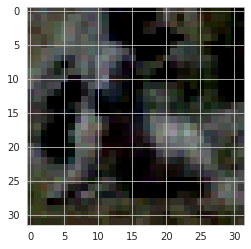

In [ ]:
# print(outputs['px'].sample())
# imshow(torchvision.utils.make_grid(outputs['px'].sample().to("cpu")))
imshow(torchvision.utils.make_grid(outputs['px'].loc.detach().to("cpu")))

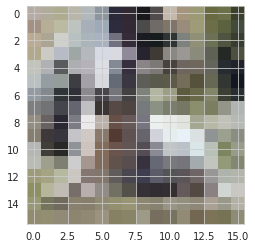

In [ ]:
imshow(torchvision.utils.make_grid(y).to("cpu"))    

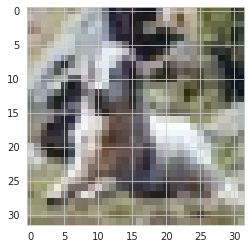

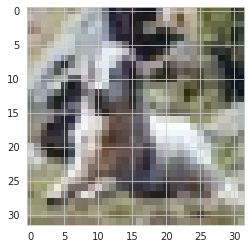

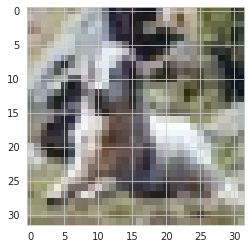

In [ ]:
imshow(torchvision.utils.make_grid(x).to("cpu"))    